## Final Project Submission

Please fill out:
* Student name: Steven Rosa
* Student pace: part time
* Project review date/time: Monday 1 April 2019 11am ET
* Instructor name: Jeff Herman
* Blog post URL:


"Database for The Scratched Voices Begging to be Heard: The Graffiti of Pompeii and Today"

by Alexa Rose

https://core.tdar.org/dataset/445837/database-for-the-scratched-voices-begging-to-be-heard-the-graffiti-of-pompeii-and-today

<a id = 'top'></a>

# Contents
- Libraries and helper functions
- [A first look at the data](#obtain)
- [Cleaning the raw data](#scrub)
- [Exploratory data analysis](#explore)
 - [Character count and imperatives](#character_imperative)
 - [How good are the categories?](#prelim_model)
 - [Detour: improving the categories](#detour_cat)
- Modeling
 - [Model \#1](#model1)
 - [Model \#2: Decision tree](#model2)
   - [Tuning Hyperparameters](#tree_tuning_hypers)
   - [Tuning with Grid Search CV](#tree_grid_search)
 - [Model \#3](#model3)
- [Conclusions](#concl)

# Libraries

In [73]:
import graffiti_functions #Import my custom functions
from graffiti_functions import plot_conf_matrix, keyword_matrix, write, hyper, compare_hypers, plot_hypers
import pandas as pd #For working with DataFrames
import matplotlib.pyplot as plt #For visualizing plots
import numpy as np #For mathematical operations
import random                   #for generating random numbers for train/test split
import copy                     #for making deep copies of mutable objects
import time                     #for timing expensive operations
from pandasql import sqldf #for manipulating DataFrames with SQL style queries

#############################
#PREPARING DATA FOR MODELING:
#To divide data when testing a trained model
from sklearn.model_selection import train_test_split 
#For scaling/normalizing, and for LabelEncoder and OneHotEncoder
from sklearn import preprocessing
#To turn categorical columns into sets of numerical columns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#####################
#LOGISTIC REGRESSION:
#For building regular logistic regression models
from sklearn.linear_model import LogisticRegression

################
#DECISION TREES:
#For building decision trees
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree 
#To find best combination of hyperparameters in decision trees
from sklearn.model_selection import GridSearchCV
#To evaluate accuracy of decision trees
from sklearn.model_selection import cross_val_score
#To visualize decision trees:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

###################
# ASSESSING MODELS:
#To assess accuracy of logistic regression or decision trees
from sklearn.metrics import confusion_matrix 
#To iteratively append labels to cells in a confusion matrix
import itertools 
#To get accuracy, precision, recall, and F1 score (weighted accuracy) of a given confusion matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#To view the accuracy metrics for a given confusion matrix
from sklearn.metrics import classification_report

In [ ]:
#Thing for separating values by hyphen slash etc



In [ ]:
#Thing for getting indexes and filling values maybe



<a id = 'obtain'></a>

[(Back to top)](#top)

# A first look at the data

In [5]:
#Obtain the raw data
df_raw = pd.read_csv('graffiti.csv')

In [ ]:
df_raw.head(20)

In [ ]:
df_raw.info()

Columns to drop:

'found'
'org'?
'comments'?

Change 'Literacy' to integer before categorizing. Rename column.

Rename 'Image ' as 'Image'.

Categorical variables to transform: Reggio, Insula, Literacy, Context type specific, Context type general, Famous House (?), Socio-economic status


Null values to fill: Reggio, Insula, Entrance, Context type specific, Context type general, Famous House,

Target: 'Category'

<a id = 'scrub'></a>

[(Back to top)](#top)

# Cleaning the data

## Column by column

### 'CIL IV Pound sign'

In [6]:
df_raw['CIL IV #'] = df_raw['CIL IV #'].fillna(0)

### 'Reggio'

In [ ]:
df_raw['Reggio'].value_counts()

In [ ]:
print(df_raw['Reggio'].isna().sum())

In [7]:
#Fill NaN values
df_raw['Reggio'] = df_raw['Reggio'].fillna(0)
#Change 6_7 to 6
df_raw.at[994, 'Reggio'] = '6'
#Change data type to integer
df_raw['Reggio'] = df_raw['Reggio'].astype('float').astype('int')

Zero values can be filled later once more is known about the reggios.

### 'Insula'

In [ ]:
df_raw['Insula'].value_counts()

In [ ]:
df_raw['Insula'].value_counts().sum()

In [ ]:
df_raw['Insula'].isna().sum()

In [8]:
#Fill null values
df_raw['Insula'] = df_raw['Insula'].fillna(0)

#Replace the values with underscores
df_raw.at[985, 'Insula'] = '4'
df_raw.at[986, 'Insula'] = '4'
df_raw.at[983, 'Insula'] = '4'
df_raw.at[984, 'Insula'] = '4'
df_raw.at[988, 'Insula'] = '9'
df_raw.at[987, 'Insula'] = '8'
df_raw.at[982, 'Insula'] = '12'
df_raw.at[981, 'Insula'] = '1'

#Change data type to intger
df_raw['Insula'] = df_raw['Insula'].astype('float').astype('int')

### 'Entrance'

In [ ]:
df_raw['Entrance'].value_counts()

In [9]:
#Fill null values
df_raw['Entrance'] = df_raw['Entrance'].fillna('unknown')

#Replace all values with underscores or hyphens
#Dict to fill values from 'Entrance'
entrance_replacements = dict()
entrance_values = df_raw['Entrance'].value_counts()

#Iterate over Entrance values to look for underscore and hyphen
#Make a dict with values to replace the _/- values in the dataframe
#I'm choosing to take the first numerical value from each pair
for index in entrance_values.index:
        if '_' in index:
            index_split = index.split('_')
            entrance_replacements[index] = index_split[0]
        elif '-' in index:
            index_split = index.split('-')
            entrance_replacements[index] = index_split[0]
            
df_raw['Entrance'] = df_raw['Entrance'].replace(entrance_replacements)

#Change 'F' to 'f'
df_raw.at[661, 'Entrance'] = df_raw.at[661, 'Entrance'].lower()
#Change '4/5/' to '4'
df_raw.at[6, 'Entrance'] = '4'
#Replace 'I' and '?'
df_raw['Entrance'] = df_raw['Entrance'].replace({'I': 'i', '?': 'unknown'})

In [ ]:
df_raw['Entrance'].value_counts().shape

This is better, but it may have to be categorized.

### 'found?'

In [ ]:
df_raw['found?'].isna().sum()

In [10]:
#Can just be dropped
df_raw.drop(['found?'], axis = 1, inplace = True)

### 'In English'

In [ ]:
df_raw['In English'].isna().sum()

In [11]:
#Fill nulls so that they can be read
df_raw['In English'] = df_raw['In English'].fillna('')

#Rows with null values or unhelpful 'CHECK' values
blank_indexes = df_raw.index[df_raw['In English'] == '']
check_indexes = df_raw.index[df_raw['In English'] == '[CHECK]']

#Drop the empty rows. They aren't useful if they don't have the English text of the graffiti.
df_raw.drop(blank_indexes, inplace = True)
df_raw.drop(check_indexes, inplace = True)

### 'org. '

In [ ]:
df_raw['org. '].value_counts()[:10]

In [12]:
#Won't be useful here. Can be dropped.
df_raw.drop(['org. '], axis = 1, inplace = True)

### 'Literacy'

In [ ]:
df_raw['Literacy (1-3)'].value_counts()

In [ ]:
df_raw['Literacy (1-3)'].isna().sum()

In [13]:
#Rename column
df_raw = df_raw.rename(index=str, columns = {'Literacy (1-3)': 'Literacy'})

#Turn the few 1 values into 2s.
df_raw['Literacy'] = df_raw['Literacy'].replace({1.0: 2})

#Fill nulls
df_raw['Literacy'] = df_raw['Literacy'].fillna(2)

#Turn floats into integers
df_raw['Literacy'] = df_raw['Literacy'].astype('float').astype('int')

### 'In org. language'

In [ ]:
df_raw['In org. language'].value_counts().sum()

In [14]:
#Dropping for now
df_raw.drop(['In org. language'], axis = 1, inplace = True)

Not sure what to do with this at this point.

### 'Context type general'

In [ ]:
df_raw['Context type general'].value_counts()

In [ ]:
df_raw['Context type general'].isna().sum()

In [15]:
# No specific, no general, no reggio, insula
no_spec_no_gen = df_raw[df_raw['Context type specific'].isna() & df_raw['Context type general'].isna()]

no_spec_no_gen[(no_spec_no_gen['Reggio'] == 0) & (no_spec_no_gen['Insula'] == 0)].shape

#Must drop the 43 rows that don't have a reggio, insula, specfic context or general context
to_drop = no_spec_no_gen[(no_spec_no_gen['Reggio'] == 0) & (no_spec_no_gen['Insula'] == 0)]
df_raw.drop(to_drop.index, axis = 0, inplace = True)

#Maybe famous house can fill in for general context where it's missing?
famoushouse_nogen = df_raw[
    (df_raw['Famous House'].notna())
    & 
    (df_raw['Context type general'].isna())]

#Get indexes of all rows without a gen context but with a famous house
indexes = famoushouse_nogen.index

famoushouse_gencontexts = {
    'Praedia ': 'building',
    'Basilica': 'basilica',
    'House of': 'house',
    'house of': 'house',
    'Villa of': 'house',
    'Building': 'building',
    'near the Porta Vesuvio': 'necropolis',
    'Workshop': 'workshop'
}

#Replace gen context with the building type from its famous house
#Iterate over all the rows which have a famous house but lack a gen context
for index in indexes:
    #Iterate over the keys of famous houses
    for key, val in famoushouse_gencontexts.items():
        #If the row's famous house matches one from the dict
        if key in df_raw.at[index, 'Famous House']:
            #Fill missing gen context value with value from dict
            df_raw.at[index, 'Context type general'] = val
            
#Noticed that Bar of Sotericus has gen context of "house"
indexes = df_raw[df_raw['Famous House'] == 'Bar of Sotericus']['Context type general']
#Replace 'house' with 'bar' for these
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'bar'
    
#Noticed that 'Outside Porta Marina' had two NaN gen contexts to fix
#Will drop these because they're missing too many columns
df_raw.drop(['997', '998'], axis = 0, inplace = True)

#change all building types for spec context "workshop" to gen context "workshop"
indexes = df_raw[df_raw['Context type specific'] == 'workshop']
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'workshop'

#Same for 'Workshop'
indexes = df_raw[df_raw['Context type specific'] == 'Workshop']
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'workshop'

#Specific context "dining room" to general context "house"
indexes = df_raw[
    (df_raw['Context type specific'] == 'dining room')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'house'

#Spec context "shop" to general context "shop"
indexes = df_raw[
    (df_raw['Context type specific'] == 'shop')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'shop'
    
#Spec context "kitchen" to general context "house"    
indexes = df_raw[
    (df_raw['Context type specific'] == 'kitchen')
    & 
    (df_raw['Context type general'].isna())]
for index in indexes.index:
    df_raw.at[index, 'Context type general'] = 'house'    
    
#Add consistency to a few of the values
replacements = {'Baths': 'baths',
                'unit': 'apartment'}
df_raw['Context type general'] = df_raw['Context type general'].replace(replacements)

#Fill null values
df_raw['Context type general'] = df_raw['Context type general'].fillna('unknown')

#Changing the name of the column
df_raw = df_raw.rename(index=str, columns ={
              'Context type general': 'Building Type'})

### 'Context type specific'

In [ ]:
df_raw['Context type specific'].value_counts()

In [16]:
#Add consistency to values
replacements = {'façade': 'facade',
                'tablinium': 'tablinum',
                'Workshop': 'workshop'
                }

df_raw['Context type specific'] = df_raw['Context type specific'].replace(replacements)

#Fill null values
df_raw['Context type specific'] = df_raw['Context type specific'].fillna('unknown')

#Rename column
df_raw = df_raw.rename(index=str, columns ={'Context type specific': 'Position'})

### 'Famous House'

In [ ]:
df_raw['Famous House'].value_counts()[60:90]

In [ ]:
df_raw['Famous House'].isna().sum()

In [17]:
#Turn this column into a 0/1 for no/yes
indexes = df_raw[df_raw['Famous House'].notna()]

for index in indexes.index:
    df_raw.at[index, 'Famous House'] = 1
    
df_raw['Famous House'] = df_raw['Famous House'].fillna(0)

df_raw['Famous House'] = df_raw['Famous House'].astype('int')

### Target: 'Category'

In [ ]:
df_raw['Category'].value_counts()

In [18]:
#Replace all values with back slashes
#Dict to fill values from 'Category'
cat_replacements = dict()
cat_values = df_raw['Category'].value_counts()

#Iterate over Category values to look for underscore and hyphen
#Make a dict with values to replace the _/- values in the dataframe
#I'm choosing to take the first value from each pair
for index in cat_values.index:
        if '/' in index:
            index_split = index.split('/')
            cat_replacements[index] = index_split[0]
            
df_raw['Category'] = df_raw['Category'].replace(cat_replacements)

#This creates one instance of 'Political' with a space
df_raw['Category'] = df_raw['Category'].replace({'Political ': 'Political'})

#Fill null values
df_raw['Category'] = df_raw['Category'].fillna('unknown')

### 'Written by'

In [ ]:
df_raw['Written by'].value_counts()

In [19]:
#Fill null values first so str.contains can be used
df_raw['Written by'] = df_raw['Written by'].fillna('unknown')

#Clean up instances of ovid
ovids = df_raw[df_raw['Written by'].str.contains('Ovid', regex = False, case = False)]
for index in ovids.index:
    df_raw.at[index, 'Written by'] = 'Ovid'

#Clean up instances of virgil    
virgils = df_raw[df_raw['Written by'].str.contains('rgil', regex = False, case = False)]
for index in virgils.index:
    df_raw.at[index, 'Written by'] = 'Virgil'

#People who look like real writers as taken from value_counts    
writers = ['Antheros', 'Ennius', 'Epaphra', 
           'Virgil', 'Horace', 'Homer', 
           'Herodotus', 'Lucretius', 'Menander',
           'Ovid', 'poem', 'Propertius',
           'Salvius', 'Senica', 'Tibutinus']
                
#Iterate over all rows to replace values with 1 for a writer
#or zero for no writer
for index in df_raw.index:
    if any(writer in df_raw.at[index, 'Written by'] for writer in writers):
        df_raw.at[index, 'Written by'] = 1
    else:
        df_raw.at[index, 'Written by'] = 0
        
#Change name of column to 'Writer'
df_raw = df_raw.rename(index=str, columns ={'Written by': 'Writer'})

### 'Work', 'Meter', and 'Reptition'

In [20]:
#Change 'Work' to 0/1 no/yes
indexes = df_raw[df_raw['Work'].notna()]
for index in indexes.index:
    df_raw.at[index, 'Work'] = 1    
df_raw['Work'] = df_raw['Work'].fillna(0)


#Change meter to 0/1 no/yes  
indexes = df_raw[df_raw['Meter'].notna()]
for index in indexes.index:
    df_raw.at[index, 'Meter'] = 1    
df_raw['Meter'] = df_raw['Meter'].fillna(0)  

#Smush together Writer Work and Meter
indexes = df_raw[(df_raw['Writer'] == 0)
        &
        (
            (df_raw['Work'] == 1) 
            | 
            (df_raw['Meter'] == 1)
        )]

for index in indexes.index:
    df_raw.at[index, 'Writer'] = 1
    
#Reassign the category for these smushed together 
indexes = df_raw[df_raw['Writer'] == 1]

for index in indexes.index:
    df_raw.at[index, 'Category'] = 'Reference'

#Reset data type for Writer to int    
df_raw['Writer'] = df_raw['Writer'].astype('int')

#Meter, Work and Repetition can be dropped
df_raw.drop(['Meter', 'Work', 'Repetition'], axis = 1, inplace = True)

### 'Foreign language'

In [ ]:
df_raw['Foreign language'].value_counts()

In [ ]:
df_raw['Foreign language'].isna().sum()

In [21]:
#Can be dropped
df_raw.drop(['Foreign language'], axis = 1, inplace = True)

### 'Image '

In [22]:
#Get rid of the annoying space in the name
df_raw = df_raw.rename(index=str, columns = {'Image ': 'Image'})

#Fill nulls first so str.contains can be used
df_raw['Image'] = df_raw['Image'].fillna('none')

#Get all rows with gladiator in the image description
gladiators = df_raw[df_raw['Image'].str.contains('gladiator', regex = False, case = False)]

for index in gladiators.index:
    df_raw.at[index, 'Category'] = 'Violence'
    
#Drop the column
df_raw.drop(['Image'], axis = 1, inplace = True)

### 'Flohr Score'

In [ ]:
df_raw['Flohr Score'].value_counts()

In [23]:
#Replace all values with hyphens.
#Dict to fill values from 'Flohr Score'
flohr_replacements = dict()
flohr_values = df_raw['Flohr Score'].value_counts()

#Iterate over values to look for hyphen
#Make a dict with values to replace the - values in the dataframe
#I'm choosing to take the first numerical value from each pair
for index in flohr_values.index:
        if '-' in index:
            index_split = index.split('-')
            flohr_replacements[index] = index_split[0]
            
df_raw['Flohr Score'] = df_raw['Flohr Score'].replace(flohr_replacements)

#Get indexes for empty Flohr scores at each SES level
low = df_raw[
        (df_raw['Socio-economic status'] == 'low')
        &
        (df_raw['Flohr Score'].isna())   ]
med = df_raw[
        (df_raw['Socio-economic status'] == 'medium')
        &
        (df_raw['Flohr Score'].isna())]
high = df_raw[
        (df_raw['Socio-economic status'] == 'high')
        &
        (df_raw['Flohr Score'].isna())]

#Then fill null values with zeros so that means can be taken
df_raw['Flohr Score'] = df_raw['Flohr Score'].fillna(0.0)

#Change strings to floats
df_raw['Flohr Score'] = df_raw['Flohr Score'].astype('float')

#Get the average Flohr score for low SES rows
low_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'low']).mean()
#Get the average Flohr score for medium SES rows
med_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'medium']).mean()
#Get the average Flohr score high SES rows
high_avg = np.array(df_raw['Flohr Score'][df_raw['Socio-economic status'] == 'high']).mean()

#Update the FLohr score for low SES rows
for index in low.index:
    df_raw.at[index, 'Flohr Score'] = low_avg
#Update the FLohr score for medium SES rows
for index in med.index:
    df_raw.at[index, 'Flohr Score'] = med_avg
#Update the FLohr score for high SES rows
for index in high.index:
    df_raw.at[index, 'Flohr Score'] = high_avg

### 'Socio-economic status'

In [ ]:
df_raw['Socio-economic status'].value_counts()

In [24]:
df_raw['Socio-economic status'] = df_raw['Socio-economic status'].fillna('medium')

### 'comments'

In [ ]:
df_raw['comments'].value_counts()


In [25]:
#interesting, further investigation could lead ot help with categorizing, but will drop for now
df_raw.drop(['comments'], axis = 1, inplace = True)

<a id = 'explore'></a>

[(Back to top)](#top)

# Exploratory data analysis

What is a reggio?

What is an insula?

From https://sites.google.com/site/ad79eruption/pompeii/map-of-pompeii

"Pompeii, however, has an additional level of numbering. It has been divided firstly into 9 regions (Regio), numbered in Roman numerals. Each of these regions contains several Insulae which are numbered 1, 2 3, etc. As with Herculaneum, each building within an insula has its own entrance number, again numbered 1, 2, 3 etc. For example, the House of Trebius Valens is labelled (Reg III, Ins 2, 1)."

In [ ]:
df_raw['Category'].value_counts()

<a id = 'character_imperative'></a>

### Adding a character count and imperative column

'Characters' will measure the length of the text of each graffito in English. 'Imperative' will count whether it has exclamation points or not.

In [26]:
#Create Characters and Imperative columns
for index in df_raw.index:
    df_raw.at[index, 'Characters'] = len(df_raw.at[index, 'In English'])
    if '!' in df_raw.at[index, 'In English']:
        df_raw.at[index, 'Imperative'] = 1
    else: 
        df_raw.at[index, 'Imperative'] = 0
df_raw['Characters'] = df_raw['Characters'].astype('int')
df_raw['Imperative'] = df_raw['Imperative'].astype('int')

<a id = 'prelim_model'></a>

### How good are the categories? Testing with a preliminary model: plain vanilla logistic regression

The data cleaning process made me suspicious that the given categories of the data aren't going to allow for good models. Let's build a plain vanilla logistic regression to see.

In [ ]:
#Prepare the data and build a logistic regression classifier.

df = copy.deepcopy(df_raw)

#Make categories
df['Literacy'] = df['Literacy'].astype('category')
df['Position'] = df['Position'].astype('category')
df['Building Type'] = df['Building Type'].astype('category')
df['Famous House'] = df['Famous House'].astype('bool').astype('category')
df['Socio-economic status'] = df['Socio-economic status'].astype('category')
df['Writer'] = df['Writer'].astype('bool').astype('category')
df['Category'] = df['Category'].astype('category')
df['Imperative'] = df['Imperative'].astype('bool').astype('category')

#Continuous data: 'Reggio', 'Insula', 'Characters', 'Flohr Score'

#Get dummies
literacy_dummies = pd.get_dummies(df['Literacy'], prefix = 'Literacy')
position_dummies = pd.get_dummies(df['Position'], prefix = 'Position')
build_type_dummies = pd.get_dummies(df['Building Type'], prefix = 'Building_Type')
famous_dummies = pd.get_dummies(df['Famous House'], prefix = 'Famous')
econ_status_dummies = pd.get_dummies(df['Socio-economic status'], prefix = 'Econ_Status')
writer_dummies = pd.get_dummies(df['Writer'], prefix = 'Writer')
imperative_dummies = pd.get_dummies(df['Imperative'], prefix = 'Imperative')

X = df.drop(['CIL IV #', 'Entrance', 'Literacy', 'In English', 
             'Position', 'Building Type', 
             'Famous House', 'Category', 'Socio-economic status',
             'Writer', 'Imperative'
            ], axis = 1)
X = pd.concat([X, literacy_dummies, position_dummies, build_type_dummies, 
               famous_dummies, econ_status_dummies, writer_dummies,
             imperative_dummies
              ], axis = 1)

y = df['Category']

#Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
#print(y_train.value_counts(),'\n', y_test.value_counts())

#Build a logistic regression model
logreg = LogisticRegression(fit_intercept=False, C=1e16)

In [ ]:
logreg.fit(X_train, y_train)

#Generate predicted values for y to compare to real values
y_hat_train = logreg.predict(X_train)

#Now generate predicted values for the test data to compare
y_hat_test = logreg.predict(X_test)

#Create a confusion matrix with the training results
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#Create a confusion matrix with the test results
conf_matrix_test = confusion_matrix(y_hat_test, y_test)

#Create labels for the classes in the conf matrix
class_names = set(y)

In [ ]:
#Draw a figure
plt.figure(figsize = (10,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_train, classes = class_names)

In [ ]:
print(classification_report(y_train, y_hat_train, target_names = class_names))

Discuss

In [ ]:
plt.figure(figsize = (10,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_test, classes = class_names)

In [ ]:
print(classification_report(y_test, y_hat_test, target_names = class_names))

This model is almost useless! It only classifies 'Reference', 'Insult', and 'Violence.'

<a id = 'detour_cat'></a>

### Detour: improving the categories

I'm unhappy with the categories and think I can do better.

In [ ]:
cat_counts = df_raw['Category'].value_counts()

In [ ]:
#COLROS ARE BROKEN

#colors_for_orig_cats = ['lavender', 'brown', 'yellow', 'blue', 'lightblue', 'purple',
#                       'maroon', 'red', 'pink', 'darkblue', 'gray']
fig = plt.figure(figsize = (8,8))
plt.pie(x = cat_counts, labels = cat_counts.index)
plt.title('Distribution of data into categories')
plt.show()

There are two problems to solve:

 1. Categories are imprecise. (What isn't "social"?)
 2. Data is unevenly distributed into these categories

Before I try to up- or down-sample I'd like to see if I can rearrange the data within the categories. I've browsed the English translations of the graffiti and have spotted some key words that I want to count the incidence of across the categories. This may suggest some more precise categories for the data. It may also allow for more even data distribution across categories.

In [27]:
#A new df for the reorganized categories
df_clean = copy.deepcopy(df_raw)

In [28]:
#A lambda function with the "globals" so I don't have to pass them in every time
pysqldf = lambda q: sqldf(q, globals())

In [29]:
categories = list(df_raw['Category'].unique())

#Some possible new categories
#Hoping to draw values out from 'Social'
love = ['the girls', 'love', 'venus']
slave = ['servant', 'serve', 'slave']
emperor = ['Caesar', 'emperor', 'Nero']
gods = ['Jupiter', 'god', 'holy', 'pray']
greeting = ['bye', 'hello', 'goodbye', 'greetings']
glory = ['fight', 'mars','soldier', 'victor']
########## WARNING!! NSFW ################
lewd = ['bugger', 'cock', 'cunt', 'faggot', 'fuck', 'suck']
###########################################
blessing = ['best wishes', 'bravo',  'favor', 'favour', 'good luck', 'happy', 'smile']
curse = ['anger', 'beware', 'curse']
keyword_cats = [love, slave, emperor, gods, greeting, glory, lewd, blessing, curse]

#A list of all keywords
keywords = []
for cat in keyword_cats:
    for word in cat:
        keywords.append(word)
        
#Build a 'keyword matrix' with my custom function
#to show incidence of the above keywords in the 
#original categories of the data.
keywords_df = keyword_matrix(pysqldf, categories, keywords)

In [30]:
keywords_df

,Key_Word,Religious,Civic,Insult,Reference,Tagging,Social,Sexual,Romantic,unknown,Political,Violence
0,the girls,0,0,0,0,4,0,1,0,0,0,1
1,love,3,0,2,18,0,0,2,40,0,0,0
2,venus,12,0,0,5,1,1,2,0,0,0,1
3,servant,0,0,1,0,0,1,0,0,0,0,0
4,serve,0,4,0,1,0,0,0,0,0,0,0
5,slave,2,2,4,0,3,5,7,1,0,1,0
6,Caesar,0,1,1,0,0,0,0,0,0,3,2
7,emperor,1,0,0,0,1,0,0,0,0,3,0
8,Nero,1,0,1,0,1,2,1,0,0,5,5
9,Jupiter,0,0,1,0,0,1,0,0,0,0,0


In [ ]:
#Opportunity to knock off many of the values from 'Social.'
keywords_df['Social'].sum()

In [31]:
#Categorize greetings, blessings, and curses as Hails 
#Hello, goodbye, good luck, go to hell)
hails = []
for words in [greeting, blessing, curse]:
    for word in words:
        hails.append(word)
write(df_clean, hails, 'In English', 'Category', 'Hail')

#Categorize references to emperors or slaves as Political
poli = []
for words in [emperor, slave]:
    for word in words:
        poli.append(word)
write(df_clean, poli, 'In English', 'Category', 'Political')

#Categorize glory words as Violence
write(df_clean, glory, 'In English', 'Category', 'Violence')
#Categorize lewd words as Lewd (new category)
write(df_clean, lewd, 'In English', 'Category', 'Lewd')
#Categorize love words as Romantic
write(df_clean, love, 'In English', 'Category', 'Romantic')
#Categorize gods words as Religious
write(df_clean, gods, 'In English', 'Category', 'Religious')

#Now:
#Combine 'Violence' and 'Political' into 'Glory'
write(df_clean, ['Violence', 'Political'], 'Category', 'Category', 'Glory')
#Combine 'Sexual' and 'Romantic' into 'Love'
write(df_clean, ['Sexual', 'Romantic'], 'Category', 'Category', 'Love')
#Combine 'unknown' and 'Tagging' into 'Civic'
write(df_clean, ['unknown', 'Tagging'], 'Category', 'Category', 'Civic')
#Combine 'Insult' with 'Hail' (They're both direct adresses)
write(df_clean, ['Insult'], 'Category', 'Category', 'Hail')
#Combine 'Religious' with 'Glory' (Politics, War, and Religion are all heady)
write(df_clean, ['Religious'], 'Category', 'Category', 'Glory')

#Now:
#Give the final categories jazzier names
replacements = {'Reference': 'Literature',
                'Social': 'Gossip',
                'Civic': 'Bulletin',
                'Religion': 'Gods'
                }
df_clean['Category'] = df_clean['Category'].replace(replacements)

How did all this work affect our categories?

In [ ]:
#FOR RTESTING
#labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
#fracs = [15, 30, 45, 10]

#fig = plt.figure()

#ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
#ax1.pie(fracs, labels=labels, radius = 1.2)
#ax2 = fig.add_axes([.5, .0, .5, .5], aspect=1)
#ax2.pie(fracs, labels=labels, radius = 1.2)
#plt.show()

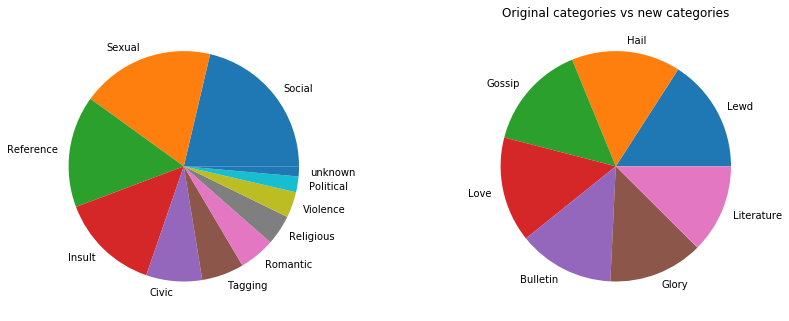

In [32]:
cat_counts = df_raw['Category'].value_counts()

#Colors for new categories
colors_for_new_cats = ['green', 'yellow', 'purple', 'gray', 'blue', 'red', 'brown']

#Values of old categories to count
cat_counts = df_raw['Category'].value_counts()
#Capture the values of the new categories to plot
v2cat_counts = df_clean['Category'].value_counts()

#Plot old categories side by side with new ones
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_axes([0, 0, .5, .5], aspect = 1)
ax1.pie(x = cat_counts, labels = cat_counts.index)
ax2 = fig.add_axes([0.5, 0, .5, .5], aspect = 1)
ax2.pie(x = v2cat_counts, labels = v2cat_counts.index)
#Need to fix title position
plt.title('Original categories vs new categories')
plt.show()

### MAKE THE COLORS CORRESPOND
Lavender   'Sexual', 'Love'
Brown   'Reference', 'Literature'
Yellow     'Insult', 'Hail'
Blue       'Civic', 'Bulletin'
Light blue 'Tagging', 'Bulletin'
Purple    'Romantic', 'Love'
Maroon    'Religious', 'Glory'
Red       'Violence', 'Glory'
Pink     'Political', 'Glory'
Dark blue  'unknown'], 'Bulletin'
Gray .      Social .     Gossip

Lewd  Green
Hail Yellow
Love Purple
Gossip Gray
Bulletin Blue
Glory Red
Literature Brown

In [ ]:
df_clean['Category'].value_counts()

Much better!

*Lewd*: Swear words and body parts

*Hail*: Hello, goodbye, bless you, curse you

*Love*: Romance & sex

*Gossip*: Have you heard who was drinking wine with Euphabia?

*Bulletin*: I baked bread today; I sold some pots today

*Glory*: The slaves won the battle! The emperor won the battle! The gods helped us win the battle!

*Literature*: Ovid, Aenid, Homer, Horace: we've got all the classics

Now let's see how this data performs with a plain vanilla logistic regression model.

### Another plain vanilla logistic regression with the new categories

In [ ]:
#Prepare the data

df = copy.deepcopy(df_clean)

#Make categories
df['Literacy'] = df['Literacy'].astype('category')
df['Position'] = df['Position'].astype('category')
df['Building Type'] = df['Building Type'].astype('category')
df['Famous House'] = df['Famous House'].astype('bool').astype('category')
df['Socio-economic status'] = df['Socio-economic status'].astype('category')
df['Writer'] = df['Writer'].astype('bool').astype('category')
df['Category'] = df['Category'].astype('category')
df['Imperative'] = df['Imperative'].astype('bool').astype('category')

#Continuous data: 'Reggio', 'Insula', 'Characters', 'Flohr Score'

#Get dummies
literacy_dummies = pd.get_dummies(df['Literacy'], prefix = 'Literacy')
position_dummies = pd.get_dummies(df['Position'], prefix = 'Position')
build_type_dummies = pd.get_dummies(df['Building Type'], prefix = 'Building_Type')
famous_dummies = pd.get_dummies(df['Famous House'], prefix = 'Famous')
econ_status_dummies = pd.get_dummies(df['Socio-economic status'], prefix = 'Econ_Status')
writer_dummies = pd.get_dummies(df['Writer'], prefix = 'Writer')
imperative_dummies = pd.get_dummies(df['Imperative'], prefix = 'Imperative')

X = df.drop(['CIL IV #', 'Entrance', 'Literacy', 'In English', 
             'Position', 'Building Type', 
             'Famous House', 'Category', 'Socio-economic status',
             'Writer', 'Imperative'
            ], axis = 1)
X = pd.concat([X, literacy_dummies, position_dummies, build_type_dummies, 
               famous_dummies, econ_status_dummies, writer_dummies,
             imperative_dummies
              ], axis = 1)

y = df['Category']

#Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)
#print(y_train.value_counts(),'\n', y_test.value_counts())

In [ ]:
#Build a logistic regression model
logreg = LogisticRegression(fit_intercept=False, C=1e16)

Fit the classifier to the training data
logreg.fit(X_train, y_train)

#Generate predicted y values for training set
y_hat_train = logreg.predict(X_train)

#Generate predicted y values for testing set
y_hat_test = logreg.predict(X_test)

#Create a confusion matrix for the training set
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#Create a confusion matrix for the testing set
conf_matrix_test = confusion_matrix(y_hat_test, y_test)

#Create labels for the classes in the conf matrix
class_names = set(y)
#Draw a figure
#plt.figure(figsize = (8,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_train, title = 'Training set', classes = class_names)

In [ ]:
print(classification_report(y_train, y_hat_train, target_names = class_names))

In [ ]:
#plt.figure(figsize = (8,8))
#Call the custom function to draw the conf matrix
plot_conf_matrix(conf_matrix_test, title = 'Test set', classes = class_names)

In [ ]:
print(classification_report(y_test, y_hat_test, target_names = class_names))

The first model could only classify 3 out of 11 categories. The second model can classify all 7 of its categories, and it does a good job on 4 out of 7. Its accuracy is actually slightly lower than the first.

<a id = 'model1'></a>

[(Back to top)](#top)

# Modeling: Model \#1

<a id = 'model2'></a>

[(Back to top)](#top)

# Model \#2

## Decision trees

In [33]:
df = copy.deepcopy(df_clean)

Preparing the data:

In [34]:
class_names = set(df['Category'])

# Create label encoder instance
lb = LabelEncoder() 

# Create Numerical labels for categorical columns
df['Literacy_'] = lb.fit_transform(df['Literacy'])
df['Position_'] = lb.fit_transform(df['Position'])
df['Build_Type_'] = lb.fit_transform(df['Building Type'])
df['Famous_'] = lb.fit_transform(df['Famous House'])
df['Writer_'] = lb.fit_transform(df['Writer'])
df['Econ_Status_'] = lb.fit_transform(df['Socio-economic status'])
df['Imperative_'] = lb.fit_transform(df['Imperative'])
#the target
df['Category_'] = lb.fit_transform(df['Category'])

columns_to_encode = ['Literacy_', 'Position_', 'Build_Type_', 
                     'Famous_', 'Writer_', 'Econ_Status_', 
                     'Imperative_'
                    ]

columns_continuous = ['Reggio', 'Insula', 'Flohr Score', 
                      'Characters'
                     ]

# Split features and target variable
#X = df[columns_to_encode,]
y = df['Category_']

# Instantiate a one hot encoder
enc = OneHotEncoder()

# Fit the feature set X
enc.fit(df[columns_to_encode])

# Transform X's encoded columns to onehot array 
onehotX = enc.transform(df[columns_to_encode])

#Convert the sparse matrix back into a DF
X_onehot = pd.DataFrame(onehotX.todense())
#Get just the continuous columns
continuous = df[columns_continuous]
#Have to reset the index so the rows will line up with
#the rows in the encoded set
continuous.reset_index(inplace = True)
continuous.drop(['index'], axis = 1, inplace = True)

#Bring back together the encoded columns and the continuous columns
X = pd.concat([X_onehot, continuous], axis = 1)

# Create a 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## A plain vanilla decision tree

In [35]:
# Train the classifier and make predictions
clf = DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X_train,y_train) 
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)

### Visualize the result

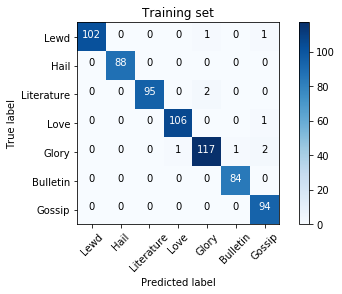

In [36]:
#Create confusion matrices with the results

class_names = set(df['Category'])

#A CM for the training set
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#A CM for the test set
conf_matrix_test = confusion_matrix(y_hat_test, y_test)

#Draw the training CM
plot_conf_matrix(conf_matrix_train, title = 'Training set', classes = class_names)

In [ ]:
print(classification_report(y_train, y_hat_train, target_names = class_names))

Very over-fitted!

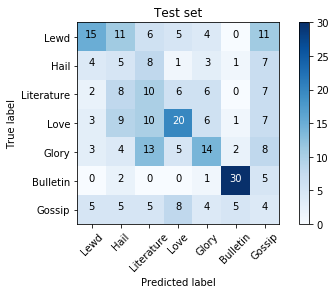

In [37]:
#Draw the test CM
plot_conf_matrix(conf_matrix_test, title = 'Test set', classes = class_names)

In [ ]:
print(classification_report(y_test, y_hat_test, target_names = class_names))

In [ ]:
#Image = draw_graph(clf)

In looking at the graph I notice that X_54, 'Characters' appears again and again.

In [78]:
plain_cv_score = cross_val_score(clf, X_train, y_train, cv=3)
mean_plain_cv_score = np.mean(cv_score)

print("Mean Cross Validation Score: {:.4}%".format(mean_plain_cv_score * 100))

Mean Cross Validation Score: 33.51%


In [38]:
#MAybe useful for interpreting graph
print('Features:', clf.n_features_)
print('Tree depth:', clf.tree_.max_depth)
print('Nodes and leaves:', clf.tree_.node_count)
print('"Capacity":', clf.tree_.capacity)

Features: 55
Tree depth: 21
Nodes and leaves: 731
"Capacity": 731


Accuracy is lower than plain vanilla logistic regression. 

Decision tree is very complex.

Needs hyperparameter tuning.

What about with the gini coefficient instead?

Has just slightly lower accuracy scores and 10 fewer nodes than when measuring entropy.

<a id = 'tree_tuning_hypers'></a>

[(Back to top)](#top)

## Decision tree: tuning hyperparameters

### Compare information-loss criterion

In [ ]:
# Train the classifier and make predictions
clf = DecisionTreeClassifier(criterion = 'gini')
clf.fit(X_train,y_train) 
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)

class_names = set(df['Category'])

#A CM for the training set
conf_matrix_train = confusion_matrix(y_hat_train, y_train)
#A CM for the test set
conf_matrix_test = confusion_matrix(y_hat_test, y_test)
print(classification_report(y_train, y_hat_train, target_names = class_names))
print(classification_report(y_test, y_hat_test, target_names = class_names))

Discuss

In [ ]:
print('Features:', clf.n_features_)
print('Tree depth:', clf.tree_.max_depth)
print('Nodes and leaves:', clf.tree_.node_count)
print('"Capacity":', clf.tree_.capacity)

Let's tun some of these other parameters.

### Compare values of max_depth

In [39]:
print('Max depth of original tree:', clf.tree_.max_depth)

Max depth of original tree: 21


/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


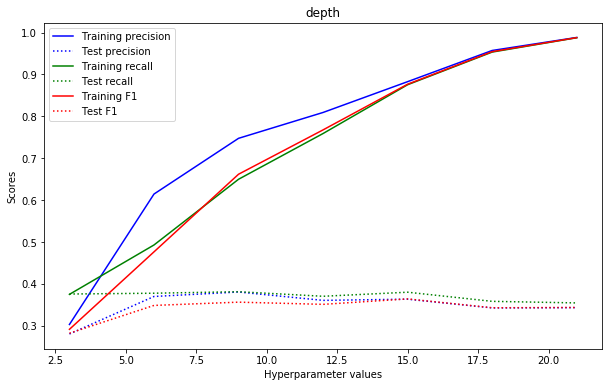

In [40]:
#Set values of chosen hyperparameter
depth_params = np.arange(3, 22, 3)
#Run model for each param value and store scores
depth_df = compare_hypers(depth_params, 'depth', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(depth_df, 'depth')

In [40]:
depth_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,3.0,0.302982,0.280303,0.374851,0.375712,0.291390,0.282083
1,6.0,0.614380,0.367263,0.492796,0.377594,0.476358,0.347350
2,9.0,0.747357,0.379483,0.649828,0.379916,0.661489,0.355774
3,12.0,0.806470,0.379716,0.757730,0.388834,0.766110,0.369302
4,15.0,0.883688,0.361241,0.876861,0.376973,0.878009,0.361068
5,18.0,0.958592,0.355194,0.956860,0.364905,0.957188,0.353144
6,21.0,0.988250,0.347920,0.987582,0.357453,0.987819,0.347959


### Compare values of min_samples_split

In [41]:
print('Min sample split of original tree:', 2 )

Min sample split of original tree: 2


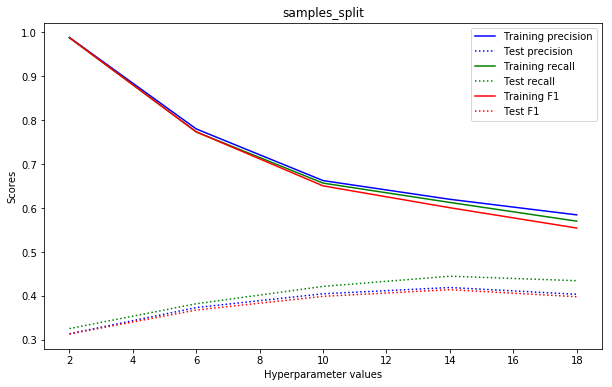

In [42]:
#Set values of chosen hyperparameter
samples_split_params = np.arange(2, 20, 4)
#Run model for each param value and store scores
samples_split_df = compare_hypers(samples_split_params, 'samples_split', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(samples_split_df, 'samples_split')

In [44]:
samples_split_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,2.0,0.988250,0.338616,0.987582,0.360219,0.987819,0.340997
1,4.0,0.862982,0.371737,0.860074,0.388822,0.858197,0.371302
2,6.0,0.780057,0.388133,0.771995,0.397033,0.771845,0.381539
3,8.0,0.724944,0.390761,0.710846,0.398797,0.707856,0.379502
4,10.0,0.666627,0.405133,0.660669,0.421564,0.654478,0.398824
5,12.0,0.628235,0.416408,0.620344,0.442070,0.608602,0.409847
6,14.0,0.619834,0.419035,0.612681,0.444804,0.600638,0.414121
7,16.0,0.607261,0.410985,0.595347,0.438810,0.579780,0.406754
8,18.0,0.584427,0.403562,0.570118,0.434546,0.554446,0.398038


### Compare values of min_samples_leaf

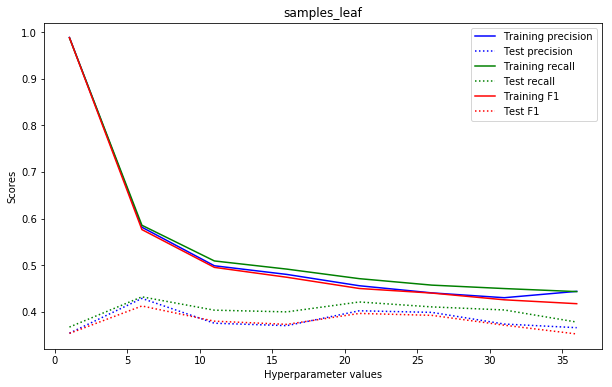

In [43]:
#Set values of chosen hyperparameter
samples_leaf_params = np.arange(1, 40, 5)
#Run model for each param value and store scores
samples_leaf_df = compare_hypers(samples_leaf_params, 'samples_leaf', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(samples_leaf_df, 'samples_leaf')

*Observations*: The test set seems to reach a peak at 5 samples per leaf.

### Compare values of max_features

In [44]:
print('Features in the original tree:', clf.n_features_)

Features in the original tree: 55


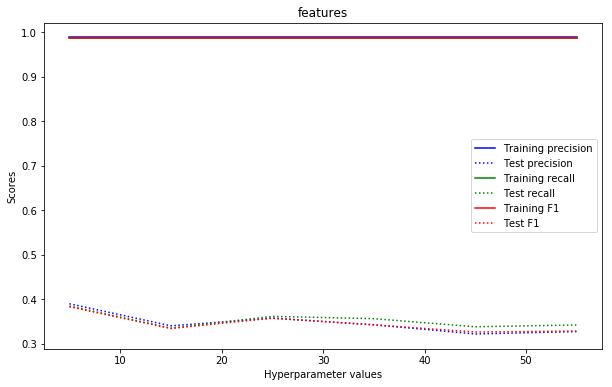

In [54]:
#Set values of chosen hyperparameter
feature_params = np.arange(5, 65, 10)
#Run model for each param value and store scores
feature_df = compare_hypers(feature_params, 'features', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(feature_df, 'features')

In [55]:
feature_df

,param_values,prec_train,prec_test,recall_train,recall_test,f1_train,f1_test
0,5.0,0.98825,0.390014,0.987582,0.384861,0.987819,0.383297
1,15.0,0.98825,0.340477,0.987582,0.335394,0.987819,0.334314
2,25.0,0.98825,0.357527,0.987582,0.361711,0.987819,0.357852
3,35.0,0.98825,0.342921,0.987582,0.356537,0.987819,0.342394
4,45.0,0.98825,0.322142,0.987582,0.338374,0.987819,0.326596
5,55.0,0.98825,0.327529,0.987582,0.342351,0.987819,0.328718


*Observations*: Scores are highest when there are only 15 features. But they're only slightly higher. At this point I don't know which features are being selected. I'd hope it were the ones at the top of the tree.

### Compare values of max_leaf_nodes

In [56]:
print('Nodes and leaves in original tree:', clf.tree_.node_count)

Nodes and leaves in original tree: 731


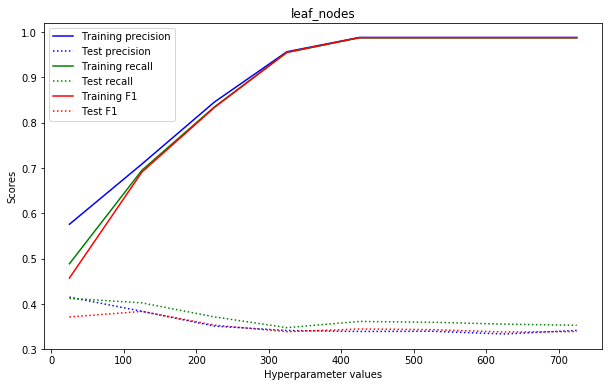

In [57]:
#Set values of chosen hyperparameter
leaf_nodes_params = np.arange(25, 800, 100)
#Run model for each param value and store scores
leaf_nodes_df = compare_hypers(leaf_nodes_params, 'leaf_nodes', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(leaf_nodes_df, 'leaf_nodes')

*Observations*: The test set gets the best results when the tree has between 50 and 75 leaves and nodes.

### Compare values of min_impurity_decrease

/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'prec

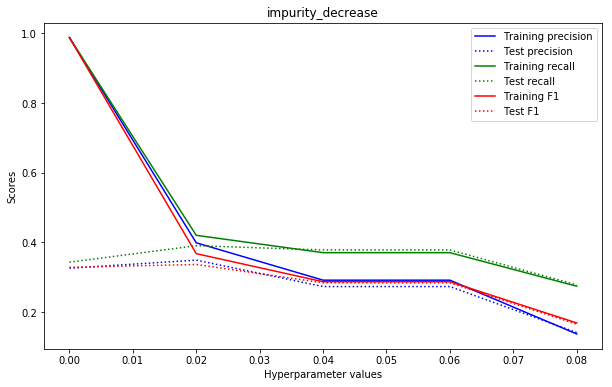

In [58]:
#Set values of chosen hyperparameter
impurity_decrease_params = np.arange(0, .1, .02)
#Run model for each param value and store scores
impurity_decrease_df = compare_hypers(impurity_decrease_params, 'impurity_decrease', X_train, X_test, y_train, y_test)
#Plot scores
plot_hypers(impurity_decrease_df, 'impurity_decrease')

*Observations*: Test set does best at impurity decrease of 0.01.

### Hyperparameter tuning summary






The most obvious conclusion is that the test set cannot break past 40% by any measure and with any individual hyperparameter tuned.

Perhaps a combination found with a GridSearch could get past 40%?

<a id = 'tree_grid_search'></a>

[(Back to top)](#top)

## Decision tree: tuning hyperparameters with GridSearchCV

In [60]:
clf = DecisionTreeClassifier()

param_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': depth_params,
    'min_samples_split': samples_split_params,
    'min_samples_leaf': samples_leaf_params,
    'max_features': feature_params,
    'max_leaf_nodes': leaf_nodes_params,
    'min_impurity_decrease': impurity_decrease_params
    }

gs_tree = GridSearchCV(clf, param_grid, cv=3)

In [65]:
#K-Folds time criteria times the rest
3 * 2 * len(depth_params) * len(samples_split_params) * len(samples_leaf_params) * len(feature_params) * len(leaf_nodes_params) * len(impurity_decrease_params)

403200

In [64]:
start = time.time()
gs_tree.fit(X_train,  y_train)
end = time.time()
print(end - start)

1462.7618942260742


/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [66]:
1462.7618942260742 / 60

24.379364903767904

In [67]:
1462.7618942260742 / 403200

0.003627881682108319

In [ ]:
24 minutes for 400,000 models. 0.003627881682108319 seconds per model.

In [68]:
gs_tree.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 45,
 'max_leaf_nodes': 225,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 16,
 'min_samples_split': 6}

In [79]:
#Don't know if I should use the training data or test data here.
#Should I scale the continuous columns?
gs_training_score = np.mean(gs_tree.cv_results_['mean_train_score'])
gs_testing_score = gs_tree.score(X_test, y_test)

print("Mean Training Score: {:.4}%".format(gs_training_score * 100))
print("Mean Testing Score: {:.4}%".format(gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search:")
gs_tree.best_params_

Mean Training Score: 31.89%
Mean Testing Score: 39.46%
Best Parameter Combination Found During Grid Search:


/Users/ssrosa/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 45,
 'max_leaf_nodes': 225,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 16,
 'min_samples_split': 6}

<a id = 'model3'></a>

[(Back to top)](#top)

# Model \#3

In [ ]:
#Having reorganized the categories
#df = copy.deepcopy(df_raw)

<a id = 'model4'></a>

[(Back to top)](#top)

# Model \#4

<a id = 'concl'></a>

[(Back to top)](#top)

# Conclusions

In [ ]:
#df_raw[df_raw['In English'].str.contains('bake', regex = False, case = False)]
